# Memetic algorithm
###### Jan Kapała & Wojciech Więckowski Evolutionary Algorithms 2021

### Import section

In [1]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.core.problem import FloatProblem
from jmetal.problem.singleobjective.unconstrained import Rastrigin, Sphere
from jmetal.core.observer import Observer
from jmetal.core.solution import FloatSolution
from jmetal.core.operator import Operator
from jmetal.operator import BestSolutionSelection, BinaryTournamentSelection, PolynomialMutation, UniformMutation, SBXCrossover
from jmetal.operator.selection import RouletteWheelSelection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.config import store

import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import random
from copy import copy, deepcopy

### Utilities

In [2]:
class DataObserver(Observer):
    def __init__(self, frequency: float = 1.0) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.observations = []

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives
            self.observations.append(fitness[0])

In [3]:
def plot_observations(all_observations, steps_to_show=80, whiskerplots_no=500, title='Whatever'):
    iterations_no = all_observations.shape[1]
    step = iterations_no//whiskerplots_no
    data = []
    for i in range(0, iterations_no, step):
        mean_observations = list(all_observations[:, i].flatten())
        data.append(mean_observations)
    data = np.array(data)
    fig = plt.figure(figsize =(20, 7))
    fig.suptitle(title, fontsize=20)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlabel('Every second step of the simulation', fontsize=18)
    ax.set_ylabel('Error', fontsize=16)
    ax.boxplot(data[:steps_to_show,:].T)

In [4]:
def population_to_points(population):
    solutions_no = len(population)
    variables_no = len(population[0].variables)
    all_variables = np.zeros((solutions_no, variables_no))

    for i in range(solutions_no):
        for j in range(variables_no):
            all_variables[i, j] = population[i].variables[j]
    xs = all_variables[:,0]
    ys = all_variables[:,1]
    return xs, ys

def neighbourhoods_to_points(ns):
    return tuple(map(np.concatenate, zip(*[population_to_points(n) for n in ns])))

In [5]:
def get_population_fitness(population):
    return list(map(lambda solution: solution.objectives[0], population)) 

### Schwefel Problem

In [6]:
class SchwefelProblem(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        super().__init__()
        self.number_of_objectives = 1
        
        self.number_of_variables = number_of_variables
        self.lower_bound = [-5.12 for _ in range(number_of_variables)]
        self.upper_bound = [5.12 for _ in range(number_of_variables)]
        
        FloatSolution.lower_bound = self.lower_bound
        FloatSolution.upper_bound = self.upper_bound
        
        self.number_of_constraints = 0

        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['f(x)']

    def evaluate(self, solution):
        result = 418.9829 * solution.number_of_variables
        x = solution.variables

        for i in range(solution.number_of_variables):
            result -= x[i] * math.sin(math.sqrt(abs(x[i])))

        solution.objectives[0] = result

        return solution

    def get_name(self):
        return 'SchwefelProblem'

### Random local Neighbourhood

This is neighbourhood operator used for local search. It maps solution to N-dimensional space - each solution variable corresponds to one dimension. It is restricted to jMetalPy FloatProblem, so variables must be floats - it is demanded for searchspace to be continues in our approach.

So each solution can be treated as a point in N-dimensional space. When Neighbourhood operator gets population it calculates extreme values of variables of solutions in this population for each dimension. This information and the neighbourhood_radius (that is a percentage) allow to calculate reasonable neighbourhood range for each dimension simply by multiplying range between extremes in this dimension by the neighbourhood_radius. In this way the neighbourhood is hyper N-dimensional cuboid with proportional dimensions.

The proces of selecting neighbours is simple: neighbours_no neighbours is sampled from the neighbourhood hypercuboid at random.

In [11]:
class RandomLocalNeighbourhood(Operator):
    def __init__(self, neighbourhood_radius, neighbours_no, problem):
        self.neighbourhood_radius = neighbourhood_radius
        self.neighbours_no = neighbours_no
        self.problem = problem
    
    def execute(self, population):
        return self._get_neighbourhoods(population)
    
    def _get_neighbourhoods_radiuses(self, population):
        solutions_no = len(population)
        variables_no = len(population[0].variables)
        all_variables = np.zeros((solutions_no, variables_no))
        
        for i in range(solutions_no):
            for j in range(variables_no):
                all_variables[i, j] = population[i].variables[j]
                
        lower_bounds = all_variables.min(axis=0)
        upper_bounds = all_variables.max(axis=0)
        
        neighbourhoods_radiuses = (upper_bounds - lower_bounds) * self.neighbourhood_radius
        return neighbourhoods_radiuses
    
    def _trimm_to_problem_bounds(self, low, high):
        for i in range(len(low)):
            low[i] = max(low[i], problem.lower_bound[i])
            high[i] = min(high[i], problem.upper_bound[i])
    
    def _get_local_neighbourhood_bounds(self, solution, neighbourhoods_radiuses):
        low = solution.variables - neighbourhoods_radiuses
        high = solution.variables + neighbourhoods_radiuses
        self._trimm_to_problem_bounds(low, high)
        
        return low, high
    
    def _get_neighbour(self, solution, low, high):
        neighbour = copy(solution)
        neighbour.variables = list(np.random.uniform(low, high))
        
        return neighbour
    
    def _get_neighbourhood(self, population, i, neighbourhoods_radiuses):
        while True:
            solution = population[i]
            low, high = self._get_local_neighbourhood_bounds(solution, neighbourhoods_radiuses)
            neighbourhood = [self._get_neighbour(solution, low, high) for _ in range(self.neighbours_no)]
        
        
            self.evaluate_single_neighbourhood(neighbourhood)
            population[i] = self.replacement_single_neighbourhood(solution, neighbourhood)
            if population[i].variables == solution.variables:
                break
        return neighbourhood
    
    def _get_neighbourhoods(self, population):
        neighbourhoods_radiuses = self._get_neighbourhoods_radiuses(population)
        neighbourhoods = []
        for i in range(len(population)):
            neighbourhoods.append(self._get_neighbourhood(population, i, neighbourhoods_radiuses)) 
            
        return neighbourhoods
    
    def evaluate_single_neighbourhood(self, neighbourhood):
        return list(map(lambda neighbour: self.problem.evaluate(neighbour), neighbourhood))
    
    
    def replacement_single_neighbourhood(self, solution, neighbourhood):
        full_neighbourhood = neighbourhood + [solution]
        full_neighbourhood.sort(key=lambda solution: solution.objectives[0])
        
        return full_neighbourhood[0]

    
    def get_name(self):
        return "Random Local Neighbourhood"

### Fixed local Neighbourhood

Another version of solving the neighbourhood problem. Instead of considering random points around the solution, this version examines one by one, solutions that adjecent to the original solution in one of the dimensions (changing one variable, while the others remain fixed).

In [25]:
class FixedLocalNeighbourhood(RandomLocalNeighbourhood):
    def __init__(self, neighbourhood_radius, problem):
        super().__init__(neighbourhood_radius, 0, problem)

        
    def execute(self, population):
        return self._get_neighbourhoods(population)

    
    def _get_neighbours(self, solution, low, high):
        neighbours =  []
        for i in range(len(solution.variables)):
            neighbour = copy(solution)
            neighbour.variables[i] -= low[i]
            neighbours.append(neighbour)
            neighbour = copy(solution)
            neighbour.variables[i] += high[i]
            neighbours.append(neighbour)

        return neighbours
    
    
    def _get_neighbourhood(self, population, i, neighbourhoods_radiuses):
        while True:
            solution = population[i]
            low, high = self._get_local_neighbourhood_bounds(solution, neighbourhoods_radiuses)
            neighbourhood = self._get_neighbours(solution, low, high)
        
        
            self.evaluate_single_neighbourhood(neighbourhood)
            population[i] = self.replacement_single_neighbourhood(solution, neighbourhood)
            if population[i].variables == solution.variables:
                break
        return neighbourhood
    

    def evaluate_single_neighbourhood(self, neighbourhood):
        return list(map(lambda neighbour: self.problem.evaluate(neighbour), neighbourhood))
    
    
    def replacement_single_neighbourhood(self, solution, neighbourhood):
        full_neighbourhood = neighbourhood + [solution]
        full_neighbourhood.sort(key=lambda solution: solution.objectives[0])
        
        return full_neighbourhood[0]

    
    def get_name(self):
        return "Fixed Local Neighbourhood"

### Local Search

Local search is the key element of the memetic algorithm. It works in the following way:
1. Neighbourhoods phase: It finds a random local neighbourhoods of each solution in the population using the operator above.
2. Evaluation phase: It evaluates all neighbours in each solution's neighbours list.
3. Replacement phase: For each solution and its corresponding neighbours list it chooses the best fitting solution of them (It is important that it do it for each solution separately)

As you can see the localsearch operator resembles an evolutionary algorithm itself.

In [13]:
class LocalSearch(Operator):
    def __init__(self, neighbourhood, problem):
        self.neighbourhood_operator = neighbourhood
        self.problem = problem
        self.last_iteration_data = {"original_population": None,
                                    "neighbourhoods": None,
                                    "refined_population": None}

    def execute(self, population):
        self.last_iteration_data["original_population"] = copy(population)
        
        if self.neighbourhood_operator.neighbours_no <= 0:
            self.last_iteration_data["refined_population"] = copy(population)
            return population
        
        if self.neighbourhood_operator.neighbourhood_radius <= 0:
            self.last_iteration_data["refined_population"] = copy(population)
            return population
        
        neighbourhoods = self.neighbourhoods(population)
        evaluated_neighbourhoods = self.evaluate(neighbourhoods)
        self.last_iteration_data["neighbourhoods"] = copy(evaluated_neighbourhoods)
        
        refined_population = self.replacement(population, evaluated_neighbourhoods)
        self.last_iteration_data["refined_population"] = copy(refined_population)

        return refined_population
    
    def neighbourhoods(self, population):
        return self.neighbourhood_operator.execute(population)
    
    def evaluate_single_neighbourhood(self, neighbourhood):
        return list(map(lambda neighbour: self.problem.evaluate(neighbour), neighbourhood))
    
    def evaluate(self, neighbourhoods):
        return list(map(lambda neighbourhood: self.evaluate_single_neighbourhood(neighbourhood), neighbourhoods))
    
    def replacement_single_neighbourhood(self, solution, neighbourhood):
        full_neighbourhood = neighbourhood + [solution]
        full_neighbourhood.sort(key=lambda solution: solution.objectives[0])
        
        return full_neighbourhood[0]
    
    def replacement(self, population, neighbourhoods):
        for i, (solution, neighbourhood) in enumerate(zip(population, neighbourhoods)):
            population[i] = self.replacement_single_neighbourhood(solution, neighbourhood)
        
        return population
            
    def get_name(self):
        return 'Local Search'

### Localsearch operator test

original population fittnes: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
original population fittnes after evaluation: [834.7279659352696, 839.4615483398899, 838.6652848405934, 835.9704285830601, 835.7398754668698, 838.3731856883669]


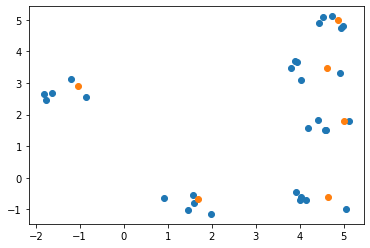

In [31]:
problem_dimensions = 2
population_size = 6
neighbourhood_radius = 0.1
neighbours_no = 5

problem = SchwefelProblem(problem_dimensions)
neighbourhood = RandomLocalNeighbourhood(neighbourhood_radius, neighbours_no, problem)
localsearch = LocalSearch(neighbourhood, problem)

population = [problem.create_solution() for _ in range(population_size)]
print(f"original population fittnes: {get_population_fitness(population)}")
population = localsearch.evaluate_single_neighbourhood(population)
print(f"original population fittnes after evaluation: {get_population_fitness(population)}")

refined_population = localsearch.execute(population)
neighbourhoods = localsearch.last_iteration_data["neighbourhoods"]
original_population = localsearch.last_iteration_data["original_population"]

plt.scatter(*neighbourhoods_to_points(neighbourhoods))
plt.scatter(*population_to_points(refined_population))

### Memetic Algorithm
A memetic algorithm is a genetic algorithm that additionally uses local search operator.
There is a lot of possibilities for local search operator - we used a random local search operator that operates in the near neighbourhood (it can be set by the percentage radius parameter).
The localsearch operator is used between offspring evaluation phase and the replacement phase (do not confuse meetic algorithm's evaluation and replacement phases with localsearch operator's own evaluation and replacement phases).

By using local search operator a memetic algorithm can in the same time use genetic, population based approach and, in general, agent based, individual approach. This autonomic search realised by each individual (that can be named agent) can be very sophisticated (even Reinforcement Learning methods) but in our case it is just local random search.

In general the family of memetic algorithm can be used to search solutions spaces that have very high level of complexity like e.g. society, but it is of course crucial to use appropriate local search operator and other parameters.

In [15]:
class MemeticAlgorithm(GeneticAlgorithm):
    def __init__(self, problem, population_size, offspring_population_size, mutation,
                 crossover, selection, localsearch,
                 termination_criterion = store.default_termination_criteria,
                 population_generator = store.default_generator,
                 population_evaluator = store.default_evaluator):
        super().__init__(problem, population_size, offspring_population_size, mutation,
                         crossover, selection, termination_criterion, population_generator,
                         population_evaluator)
        self.localsearch_operator = localsearch
    
    def localsearch(self, offspring_population):
        enriched_offspring_population = self.localsearch_operator.execute(offspring_population)
        return enriched_offspring_population
    
    def step(self):
        mating_population = self.selection(self.solutions)
        offspring_population = self.reproduction(mating_population)
        offspring_population = self.evaluate(offspring_population)
        refined_offspring_population = self.localsearch(offspring_population)
        self.solutions = self.replacement(self.solutions, refined_offspring_population)

    def get_name(self):
        return 'Memetic algorithm'

Schwefel problem using the random neighbourhood solution.

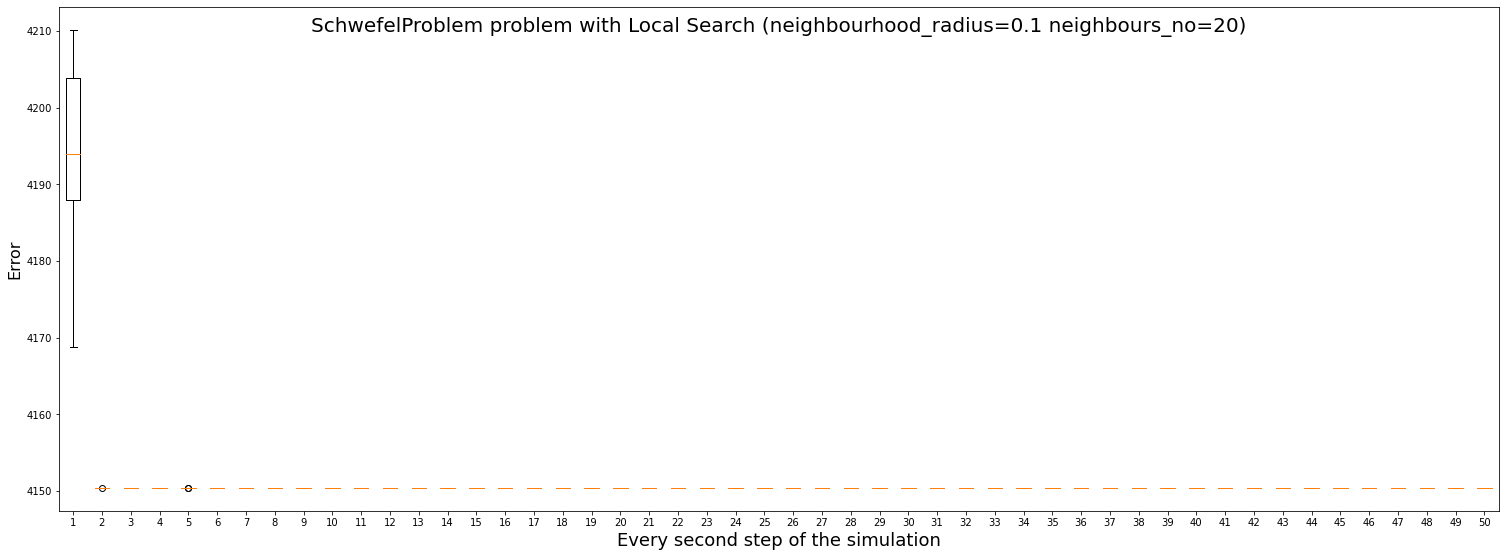

In [17]:
problem_dimensions = 10
neighbourhood_radius = 0.1
neighbours_no = 20
iterations_no = 100
experiments_no = 10
population_size = 100

problem = SchwefelProblem(problem_dimensions)
neighbourhood = RandomLocalNeighbourhood(neighbourhood_radius, neighbours_no, problem)
localsearch = LocalSearch(neighbourhood, problem)

all_observations = []

for i in range(experiments_no):
    algorithm = MemeticAlgorithm(
        problem=problem,
        population_size=population_size,
        offspring_population_size=population_size,
        mutation=UniformMutation(0.1),
        crossover=SBXCrossover(1.0),
        selection=BestSolutionSelection(),
        localsearch=localsearch,
        termination_criterion=StoppingByEvaluations(max_evaluations=population_size*iterations_no)
    )

    observer = DataObserver(1)
    algorithm.observable.register(observer)
    algorithm.run()
    all_observations.append(observer.observations)

all_observations = np.array(all_observations)
plot_observations(all_observations, steps_to_show=50, whiskerplots_no=50, 
                  title=f"{problem.get_name()} \
problem with {localsearch.get_name()} (neighbourhood_radius={neighbourhood.neighbourhood_radius} \
neighbours_no={neighbourhood.neighbours_no})")

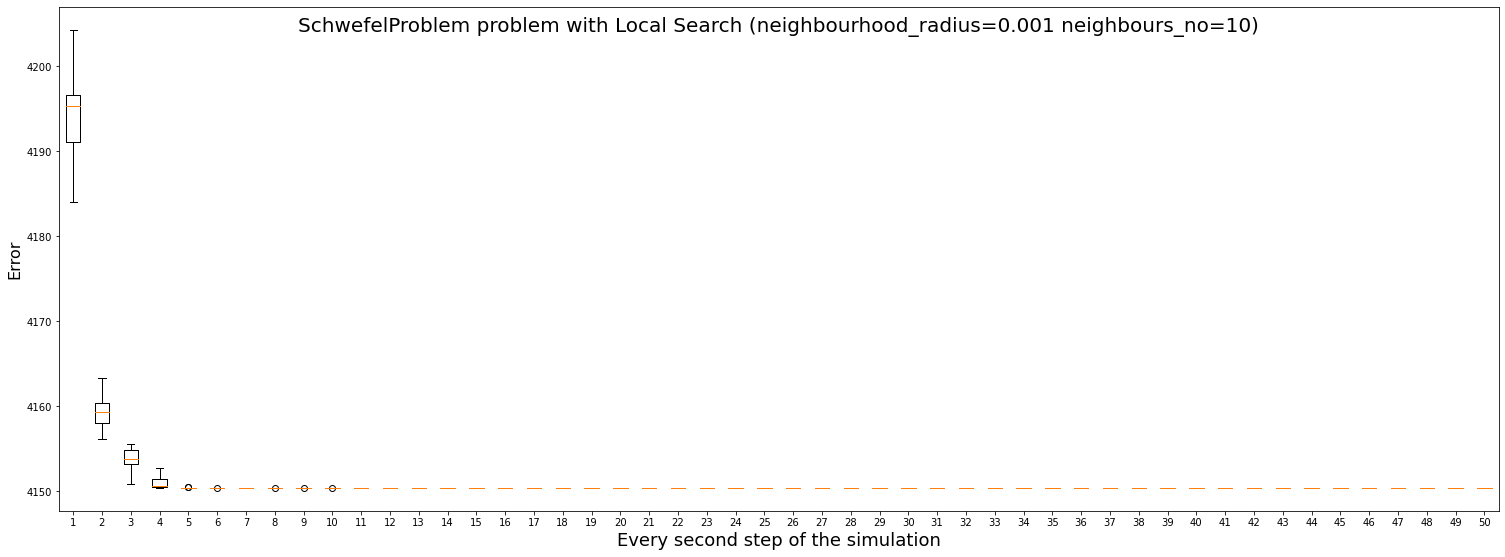

In [30]:
problem_dimensions = 10
neighbourhood_radius = 0.001
neighbours_no = 10
iterations_no = 100
experiments_no = 10
population_size = 100

problem = SchwefelProblem(problem_dimensions)
neighbourhood = RandomLocalNeighbourhood(neighbourhood_radius, neighbours_no, problem)
localsearch = LocalSearch(neighbourhood, problem)

all_observations = []

for i in range(experiments_no):
    algorithm = MemeticAlgorithm(
        problem=problem,
        population_size=population_size,
        offspring_population_size=population_size,
        mutation=UniformMutation(0.1),
        crossover=SBXCrossover(1.0),
        selection=BestSolutionSelection(),
        localsearch=localsearch,
        termination_criterion=StoppingByEvaluations(max_evaluations=population_size*iterations_no)
    )

    observer = DataObserver(1)
    algorithm.observable.register(observer)
    algorithm.run()
    all_observations.append(observer.observations)

all_observations = np.array(all_observations)
plot_observations(all_observations, steps_to_show=50, whiskerplots_no=50, 
                  title=f"{problem.get_name()} \
problem with {localsearch.get_name()} (neighbourhood_radius={neighbourhood.neighbourhood_radius} \
neighbours_no={neighbourhood.neighbours_no})")

Schwefel problem using the random neighbourhood solution.

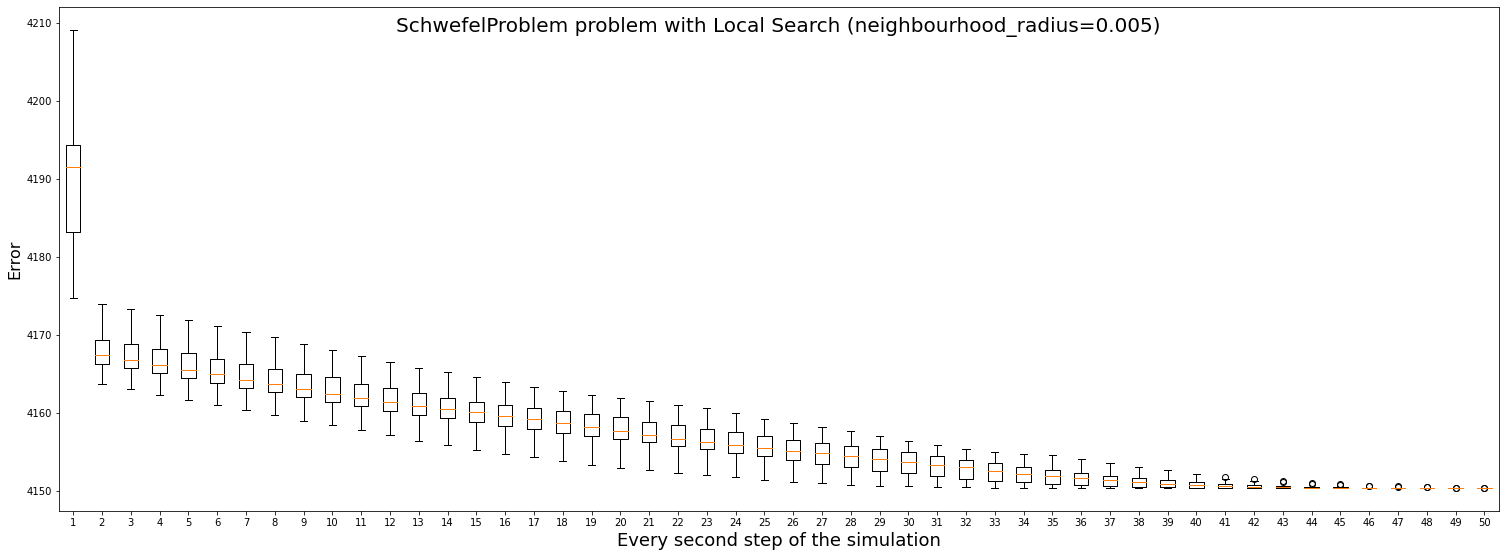

In [26]:
problem_dimensions = 10
neighbourhood_radius = 0.005
iterations_no = 100
experiments_no = 10
population_size = 100

problem = SchwefelProblem(problem_dimensions)
neighbourhood = FixedLocalNeighbourhood(neighbourhood_radius, problem)
localsearch = LocalSearch(neighbourhood, problem)

all_observations = []

for i in range(experiments_no):
    algorithm = MemeticAlgorithm(
        problem=problem,
        population_size=population_size,
        offspring_population_size=population_size,
        mutation=UniformMutation(0.1),
        crossover=SBXCrossover(1.0),
        selection=BestSolutionSelection(),
        localsearch=localsearch,
        termination_criterion=StoppingByEvaluations(max_evaluations=population_size*iterations_no)
    )

    observer = DataObserver(1)
    algorithm.observable.register(observer)
    algorithm.run()
    all_observations.append(observer.observations)

all_observations = np.array(all_observations)
plot_observations(all_observations, steps_to_show=50, whiskerplots_no=50, 
                  title=f"{problem.get_name()} \
problem with {localsearch.get_name()} (neighbourhood_radius={neighbourhood.neighbourhood_radius})")